python implementation of [Patchwork](https://mattdesl.svbtle.com/pen-plotter-2)

In [1]:
import penkit
import sklearn
import shapely
import numpy as np
from sklearn.cluster import DBSCAN
from shapely.geometry import Point, MultiPoint, MultiLineString, LineString, MultiPolygon, Polygon

import random

In [4]:
N_POINTS = 500
WIDTH = 300
HEIGHT = 300

In [3]:
def rand_between(a, b):
    return np.random.uniform(a, b)

def point(margin=2.0, min_x=0.0, min_y=0.0, max_x=WIDTH, max_y=HEIGHT):
    x = rand_between(min_x + margin, max_x - margin)
    y = rand_between(min_y + margin, max_y - margin)
    return Point(x,y)

def point_in_geom(geom):
    (min_x, min_y, max_x, max_y) = geom.bounds
    while True:
        candidate = point(margin=0.0, min_x=min_x, min_y=min_y, max_x=max_x, max_y=max_y)
        if candidate.within(geom):
            return candidate


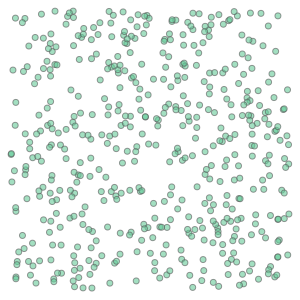

In [5]:
MultiPoint([point() for _ in range(N_POINTS)])

In [16]:
MultiPoint??

Init signature: MultiPoint(points=None)
Source:        
class MultiPoint(BaseMultipartGeometry):

    """A collection of one or more points

    A MultiPoint has zero area and zero length.

    Attributes
    ----------
    geoms : sequence
        A sequence of Points
    """

    def __init__(self, points=None):
        """
        Parameters
        ----------
        points : sequence
            A sequence of (x, y [,z]) numeric coordinate pairs or triples or a
            sequence of objects that implement the numpy array interface,
            including instances of Point.

        Example
        -------
        Construct a 2 point collection

          >>> ob = MultiPoint([[0.0, 0.0], [1.0, 2.0]])
          >>> len(ob.geoms)
          2
          >>> type(ob.geoms[0]) == Point
          True
        """
        super(MultiPoint, self).__init__()

        if points is None or len(points) == 0:
            # allow creation of empty multipoints, to support unpickling
            

In [30]:
from sklearn.cluster import KMeans
#from sklearn.cluster import AgglomerativeClustering

def patch_geom(geom, classifier, n_clusters=10, n_points=1000):
    points = [point_in_geom(geom) for _ in range(n_points)]
    
    hulls = [] 
    
    while len(points) > n_clusters:
        X = np.array([[pt.x,pt.y] for pt in points])
        clusters = classifier.fit_predict(X)

        largest_area = 0
        largest_cluster = 0
        largest_hull = None
        points_to_remove = []
        for c in range(clusters.max()):
            cluster = [points[i] for i in np.where(clusters == c)[0]]
            if not cluster:
                continue
            cluster = MultiPoint(cluster)
            hull = cluster.convex_hull.buffer(1)
            area = hull.area

            if area > largest_area:
                largest_area = area
                largest_cluster = c
                largest_hull = hull
                points_to_remove = np.where(clusters == c)[0]

        hulls.append(largest_hull)
        points = [pt for pt in points if not pt.within(largest_hull)]
    
    return hulls

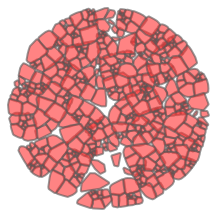

In [10]:
import random

geoms = [Point(.0,.0).buffer(100.0)]
classifier = KMeans(n_clusters=4, init='random', algorithm='elkan')

for _ in range(50):    
    geoms.sort(key=lambda x: x.area)
    geom = geoms.pop()
    geoms.extend(patch_geom(geom, classifier))

MultiPolygon(geoms)

In [52]:
with open("patchwork-kmeans-clusters[4].svg", 'w') as f:
    f.write('<svg>\n\t')
    f.write(MultiPolygon(geoms).svg())
    f.write('</svg>\n')

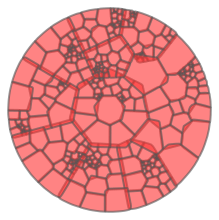

In [34]:
N_POINTS = 10000

import random

geoms = [Point(.0,.0).buffer(100.0)]
classifier = KMeans(n_clusters=8, init='random', algorithm='elkan')

for i in range(10,0,-1):    
    geoms.sort(key=lambda x: x.area)
    geom = geoms.pop()
    geoms.extend(patch_geom(geom, classifier, n_points=N_POINTS*i))

MultiPolygon(geoms)

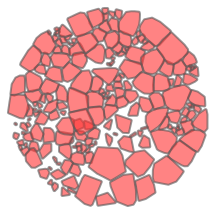

In [35]:
N_POINTS = 100

import random

geoms = [Point(.0,.0).buffer(100.0)]
classifier = KMeans(n_clusters=8, init='random', algorithm='elkan')

for i in range(10,0,-1):    
    geoms.sort(key=lambda x: x.area)
    geom = geoms.pop()
    geoms.extend(patch_geom(geom, classifier, n_points=N_POINTS*i))

MultiPolygon(geoms)

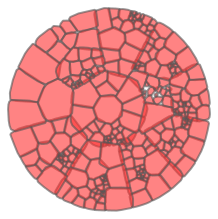

In [39]:
N_POINTS = 1000

import random

geoms = [Point(.0,.0).buffer(100.0)]
classifier = KMeans(n_clusters=8, init='k-means++', algorithm='elkan')

for i in range(10,0,-1):    
    geoms.sort(key=lambda x: x.area)
    geom = geoms.pop()
    geoms.extend(patch_geom(geom, classifier, n_points=N_POINTS*i))

MultiPolygon(geoms)

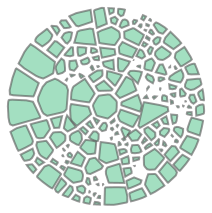

In [51]:
MultiPolygon([g.buffer(-2.71) for g in geoms])

In [52]:
out = MultiPolygon([g.buffer(-2.71) for g in geoms])

with open("patchwork-town-square.svg", 'w') as f:
    f.write('<svg>\n\t')
    f.write(out.svg())
    f.write('</svg>\n')